In [91]:
#import libraries

import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats
from scipy import signal
from cartopy import config
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import datetime

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

6

In [85]:
ds = xr.open_dataset('/Users/dessyb/Box/Patrick/ERA5/caribbean_sst.nc') #loads netcdf file with SST gridded values as a datset

nao = pd.read_csv('/Users/dessyb/Box/Patrick/ERA5/nao.csv') #loads nao_index data file to variable


In [86]:
df1 = nao[["year","month","day"]] #extracts date variables from nao_index data file

dates = pd.to_datetime(df1) #converts date variables into a single datetime variable

seasons = np.array(df1['month']%12 // 3 + 1) #creates a variable that identifies season, where winter = 1, spring =2, summer =3, autumn =4
seasons = np.transpose(seasons, axes=None) #transposes seasons to a one dimensional array

In [87]:
winter = [i for i, x in enumerate(seasons) if x == 1] #stores the indices for all winter months

In [88]:
years = np.array(nao["year"][winter])
months = np.array(nao["month"][winter])

for i in range(len(years)):
    
    if months[i] == 12:
        
        years[i] += 1

nao_winter = np.array(nao['index'])[winter] #slice of nao index values for winter months

In [89]:
ilon = len(ds.longitude) #length of longitude array in netcdf file

ilat = len(ds.latitude) #length of latitude array in netcdf file

corr_matrix = np.array([[np.nan]*ilon]*ilat) #matrix for correlations values across grid
p_values = np.array([[np.nan]*ilon]*ilat) #matrix for p values across grid

In [198]:
#for loop calculates correlation and p_values across grid
for i in range(ilon): 
    for j in range(ilat):
        
        df4 = pd.DataFrame({'year':years,'nao':nao_winter,'sst':np.array(ds.sst[0:516,0,j,i])[winter]})
        
        corr_df = df4.groupby('year').mean()

        corr_df = corr_df[corr_df['nao'].notna()]
        corr_df = corr_df[corr_df['sst'].notna()]

        if len(corr_df) > 0:
            
            corr_matrix[j][i]=scipy.stats.pearsonr(corr_df['nao'],signal.detrend(corr_df['sst']))[0]
            p_values[j][i] = scipy.stats.ttest_ind(corr_df['nao'],corr_df['sst'])[1]

/var/folders/0s/y7jwzcpd30g7fmswyypr08s80000gn/T/ipykernel_82455/775484825.py:38: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(filled_c, orientation='vertical',shrink = 0.5,ticks=np.arange(-0.4,0.8,0.1))


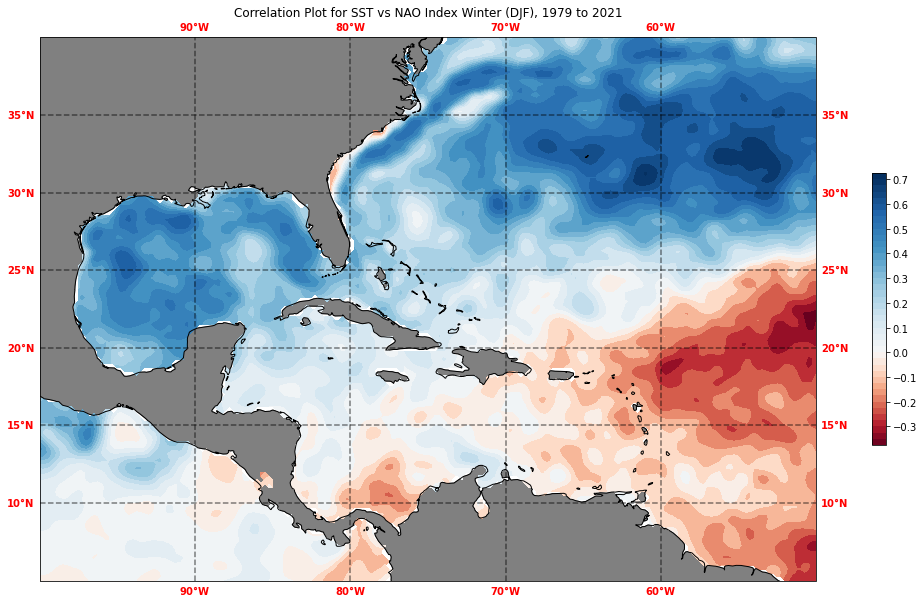

In [226]:
import cartopy.feature as cfeature
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        # Note also that we must extrapolate beyond vmin/vmax
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1.]
        return np.ma.masked_array(np.interp(value, x, y,
                                            left=-np.inf, right=np.inf))

    def inverse(self, value):
        y, x = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.interp(value, x, y, left=-np.inf, right=np.inf)

midnorm = MidpointNormalize(vmin=np.nanmin(corr_matrix), vcenter=0, vmax=np.nanmax(corr_matrix))

ax.coastlines()

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND,facecolor=("grey"))
ax.add_feature(cfeature.COASTLINE)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1.5, color='black', alpha=0.5, linestyle='--')


gl.xlabel_style = {'color': 'red', 'weight': 'bold','size': 10}
gl.ylabel_style = {'color': 'red', 'weight': 'bold','size': 10}

fig.colorbar(filled_c, orientation='vertical',shrink = 0.5,ticks=np.arange(-0.4,0.8,0.1))

plt.title("Correlation Plot for SST vs NAO Index Winter (DJF), 1979 to 2021")
#plt.savefig("winter_sst_nao.png")

filled_c = ax.contourf(ds.longitude, ds.latitude, corr_matrix,transform=ccrs.PlateCarree(),cmap='RdBu',levels=25,norm=midnorm)

#norm=MidpointNormalize(midpoint=0)


/var/folders/0s/y7jwzcpd30g7fmswyypr08s80000gn/T/ipykernel_82455/1869238257.py:21: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(filled_c, orientation='vertical',shrink = 0.5,ticks=np.arange(-0.4,0.8,0.1))


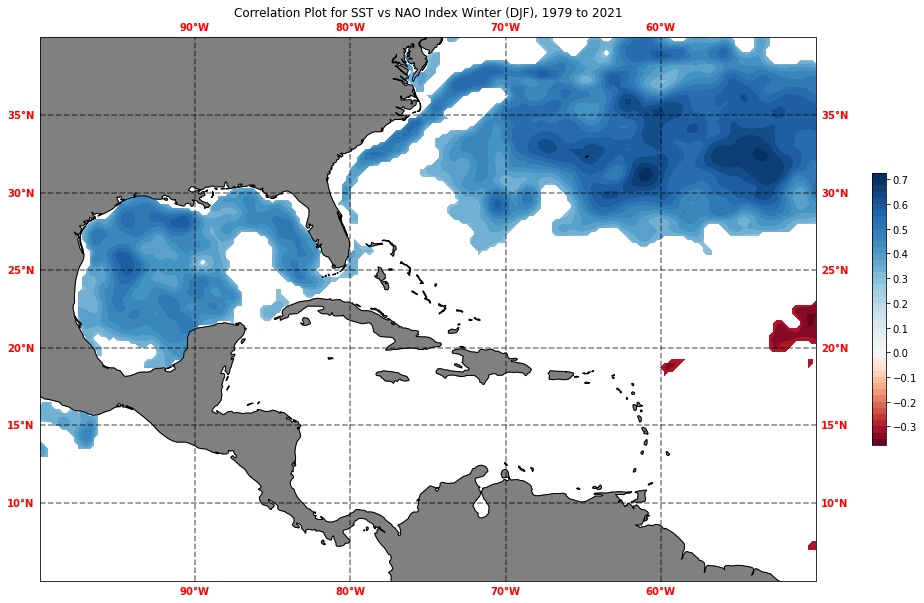

In [231]:
for i in range(ilon): 
    for j in range(ilat):
        if abs(corr_matrix[j][i]) < 0.3:
            corr_matrix[j][i] = np.nan

ax.coastlines()

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND,facecolor=("grey"))
ax.add_feature(cfeature.COASTLINE)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1.5, color='black', alpha=0.5, linestyle='--')


gl.xlabel_style = {'color': 'red', 'weight': 'bold','size': 10}
gl.ylabel_style = {'color': 'red', 'weight': 'bold','size': 10}

fig.colorbar(filled_c, orientation='vertical',shrink = 0.5,ticks=np.arange(-0.4,0.8,0.1))

plt.title("Correlation Plot for SST vs NAO Index Winter (DJF), 1979 to 2021")
#plt.savefig("winter_sst_nao.png")

filled_c = ax.contourf(ds.longitude, ds.latitude, corr_matrix,transform=ccrs.PlateCarree(),cmap='RdBu',levels=30,norm=midnorm)
